# Model Analysis

Having established the SVM regression model provides the best predictable response on new data, it will be used in the model analysis. The model analysis will focus on the data prediction and how this can be improved.

In [2]:
import pandas as pd
import shap

/home/mmcdougall/covid19-web-data-predictor/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
train_df = pd.read_csv('data/train_data.csv', index_col='Unnamed: 0')
test_df = pd.read_csv('data/test_data.csv', index_col='Unnamed: 0')

In [4]:
X_train = train_df.drop(labels=['y', 'HOSP_COUNT_7DAY_AVG', 'DEATH_COUNT_7DAY_AVG', 'popularity_rating'], axis=1)
y_train = train_df['y'].apply( lambda x: 1.0 * x)

X_test = test_df.drop(labels=['y', 'HOSP_COUNT_7DAY_AVG', 'DEATH_COUNT_7DAY_AVG', 'popularity_rating'], axis=1)
y_test = test_df['y'].apply( lambda x: 1.0 * x)

In [5]:
from sklearn.svm import LinearSVR

reg = LinearSVR()
svr_model = reg.fit(X_train, y_train)

y_pred = svr_model.predict(X_test)

## Shap Analysis

In [6]:
explainer = shap.KernelExplainer(svr_model.predict, X_train)

Using 204 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [7]:
shap_values = explainer.shap_values(X_test)

 13%|█▎        | 7/52 [00:00<00:00, 68.47it/s]

100%|██████████| 52/52 [00:00<00:00, 136.53it/s]


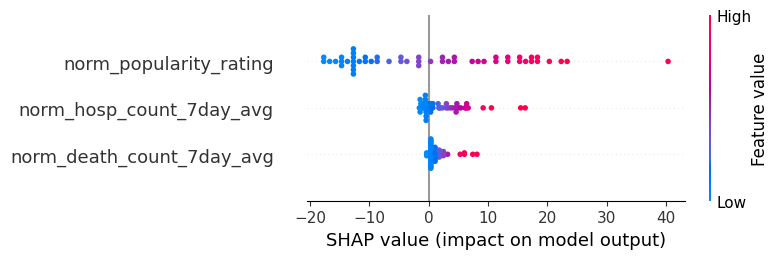

In [8]:
shap.summary_plot(shap_values, X_test)

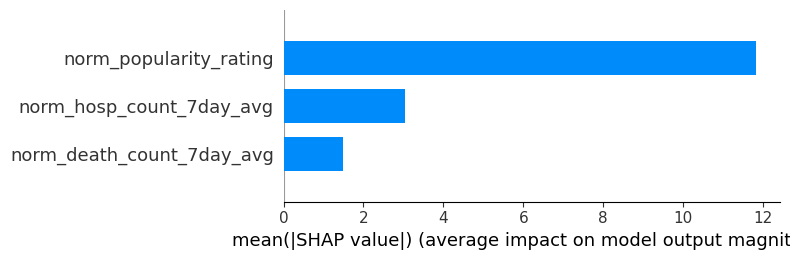

In [9]:
# 'shap_values' are the results from explainer.shap_values(X)
# 'X' is your DataFrame containing the 3 features
shap.summary_plot(shap_values, X_test, plot_type="bar")


The most significant finding here is how much the popularity rating for the search term COVID-19 influenced the outcome. The scatter plot indicates how the points the points were distributed anffor the popularity rating, it distributes almost 50/50. I will adjust the model evaluation to reflect this and see whether the results remain the same or are there other models that are more predictive.

## Model Tuning

Let's have a closer look at the model to see if it can be tuned to produce better results than what we got from the default settings.

In [10]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform
from sklearn.metrics import root_mean_squared_error

param_grid = {
    'loss' : ['epsilon_insensitive', 'squared_epsilon_insensitive'],
    'max_iter' :[1000],
    'fit_intercept' : [True],
    'intercept_scaling': uniform(0, 5)
}

model = LinearSVR()
random_search = RandomizedSearchCV(model, param_distributions=param_grid, cv=5, n_iter=1000)

In [11]:
random_search.fit(X_train, y_train)

,"estimator estimator: estimator objectAn object of that type is instantiated for each grid point.This is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",LinearSVR()
,"param_distributions param_distributions: dict or list of dictsDictionary with parameters names (`str`) as keys and distributionsor lists of parameters to try. Distributions must provide a ``rvs``method for sampling (such as those from scipy.stats.distributions).If a list is given, it is sampled uniformly.If a list of dicts is given, first a dict is sampled uniformly, andthen a parameter is sampled using that dict as above.","{'fit_intercept': [True], 'intercept_scaling': <scipy.stats....x7f46ed09baa0>, 'loss': ['epsilon_insensitive', 'squared_epsilon_insensitive'], 'max_iter': [1000]}"
,"n_iter n_iter: int, default=10Number of parameter settings that are sampled. n_iter tradesoff runtime vs quality of the solution.",1000
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.If None, the estimator's score method is used.",None
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given the ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``RandomizedSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be

In [12]:
print(random_search.best_params_)

{'fit_intercept': True, 'intercept_scaling': np.float64(2.9733392739789637), 'loss': 'epsilon_insensitive', 'max_iter': 1000}


In [13]:
from sklearn.svm import LinearSVR

reg = LinearSVR( max_iter=1000, loss='epsilon_insensitive', fit_intercept=True, intercept_scaling=1.64)
svr_model = reg.fit(X_train, y_train)

y_pred = svr_model.predict(X_test)

In [14]:
report = root_mean_squared_error(y_test, y_pred)
print(report)

294.4924135930695


<Axes: title={'center': 'Test Data Plotting'}>

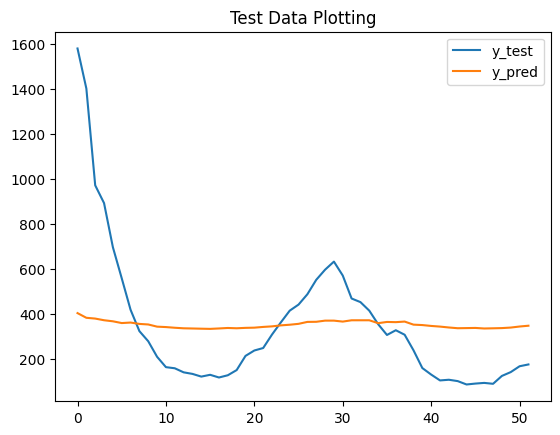

In [16]:
# let's see if we can plot both training and test data
plot_df = pd.DataFrame({'y_test': y_test.to_list(), 'y_pred': y_pred })

plot_df.plot(kind="line", title="Test Data Plotting")

In [17]:
y_pred = svr_model.predict(X_train)

<Axes: title={'center': 'Test Data Plotting'}>

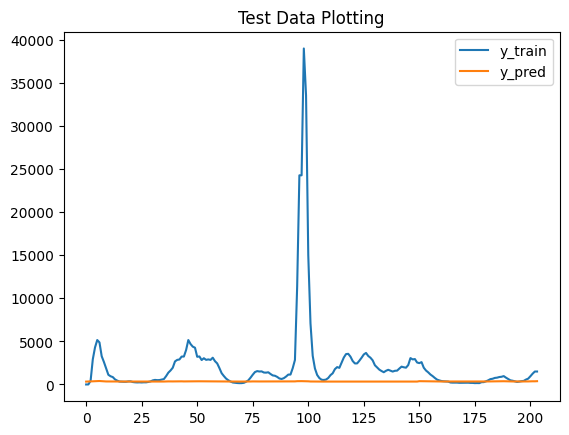

In [ ]:
# let's see if we can plot both training and test data
plot_df = pd.DataFrame({'y_train': y_train.to_list(), 'y_pred': y_pred })

plot_df.plot(kind="line", title="Training Data Plotting")

ACcording to the training plot, the LinearSVR does not do a really good job at predicting the number of cases. It behaves more like a model that is underfitting than truly predictive model.